In [1]:
from operators import *
from backtest import *
import pandas as pd
import numpy as np
import os
from typing import Iterable
# import alphalens as als
import quantstats as qs
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
qs.extend_pandas()

target_folder_path = rf'/Users/tedting/Documents/Alpha/data'
%cd "{target_folder_path}"

/Users/tedting/Documents/Alpha/data


In [2]:
adj_open = pd.read_pickle(rf'{target_folder_path}/adj_open.pkl')
#exp_returns = adj_open.pct_change().shift(-2)
exp_returns = adj_open.pct_change().shift(-2)

adj_close = pd.read_pickle(rf'{target_folder_path}/adj_close.pkl')
Returns = adj_close.pct_change()

Open = pd.read_pickle(rf'{target_folder_path}/open.pkl')
Close = pd.read_pickle(rf'{target_folder_path}/收盤價(元).pkl')
Low = pd.read_pickle(rf'{target_folder_path}/最低價(元).pkl')
High = pd.read_pickle(rf'{target_folder_path}/最高價(元).pkl')
Volume = pd.read_pickle(rf'{target_folder_path}/成交量(千股).pkl')

Limit = pd.read_pickle(rf'{target_folder_path}/limit.pkl')
ZTXA = pd.read_pickle(rf'{target_folder_path}/ZTXA_close.pkl')
Benchmark = ZTXA['ZTXA 台指近月期貨指數'].pct_change().shift(-2)

In [3]:
LogRet= np.log(Close/Close.shift(1))
R_F = LogRet.rolling(window=21).sum()

In [4]:
TotalSharesHeld = pd.read_pickle(rf'{target_folder_path}/data_daily/合計持股數(千股).pkl')
AboveThousand = pd.read_pickle(rf'{target_folder_path}/data_DM/1000張以上  (人數).pkl')
GrossProfitGrowthRate = pd.read_pickle(rf'/Users/tedting/Documents/Alpha/OFFICIAL_data_2/GrossProfitGrowthRate_q_90%.pkl')
REV_G_m = pd.read_pickle(rf'/Users/tedting/Documents/Alpha/OFFICIAL_data_2/REV_G_m_90%.pkl')
LongTermDebtDueWithinOneYear = pd.read_pickle('/Volumes/Database/Financial_report_90/  一年內到期長期負債.pkl')
OtherCurrentLiabilities = pd.read_pickle('/Volumes/Database/Financial_report_90/  其他流動負債.pkl')
DeferredIncomeTax = pd.read_pickle('/Volumes/Database/Financial_report_90/  遞延所得稅.pkl')

FinancialCost = pd.read_pickle('/Volumes/Database/Financial_report_90/財務成本.pkl')

TotalAssets = pd.read_pickle('/Volumes/Database/Financial_report_90/資產總額.pkl')
NewInvestment = pd.read_pickle('/Volumes/Database/Financial_report_90/  新增投資－CFI.pkl')


In [6]:
Volume_y_avg = Volume.rolling(252).mean()
Close_y_avg = Close.rolling(252).mean()
Volume_Filter = Volume_y_avg > 200
trade_volume_Filter = Close_y_avg * Volume_y_avg > 5000
small_aum_Filter = Volume_Filter & trade_volume_Filter

### 單因子回測

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2022-01-03  2022-01-03
End Period                 2023-11-30  2023-11-30
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          32.99%      -5.88%
CAGR﹪                     16.13%      -3.13%

Sharpe                     0.98        -0.1
Prob. Sharpe Ratio         90.27%      44.8%
Smart Sharpe               0.94        -0.09
Sortino                    1.34        -0.13
Smart Sortino              1.29        -0.13
Sortino/√2                 0.95        -0.09
Smart Sortino/√2           0.91        -0.09
Omega                      1.17        1.17

Max Drawdown               -16.41%     -31.48%
Longest DD Days            168         685
Volatility (ann.)          17.42%      17.77%
R^2                        0.06        0.06
Information Ratio          0.05        0.05
Calmar                     0.98   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-09-02,2022-10-25,2023-02-17,168,-16.409916,-15.553154
2,2022-04-19,2022-06-30,2022-09-01,135,-15.232566,-15.100555
3,2023-08-07,2023-10-30,2023-11-29,114,-8.094267,-7.435561
4,2022-01-04,2022-01-24,2022-02-17,44,-6.399798,-5.191123
5,2023-05-05,2023-05-12,2023-06-02,28,-5.716737,-5.594811


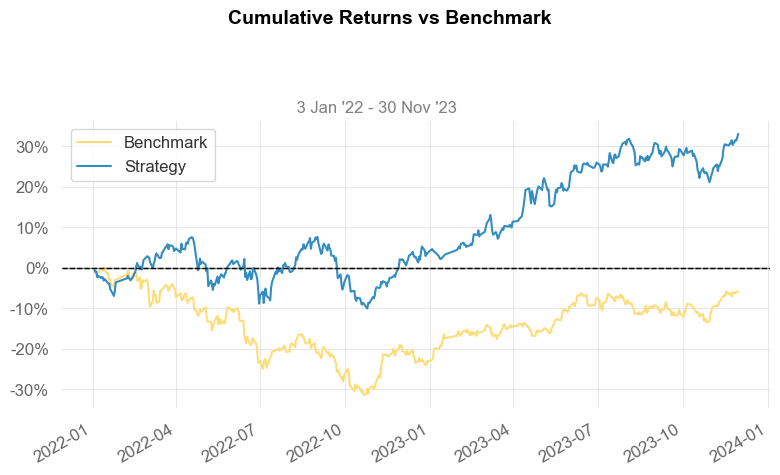

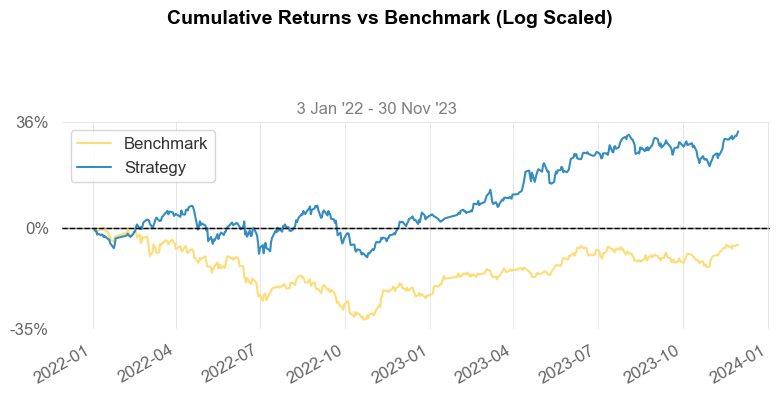

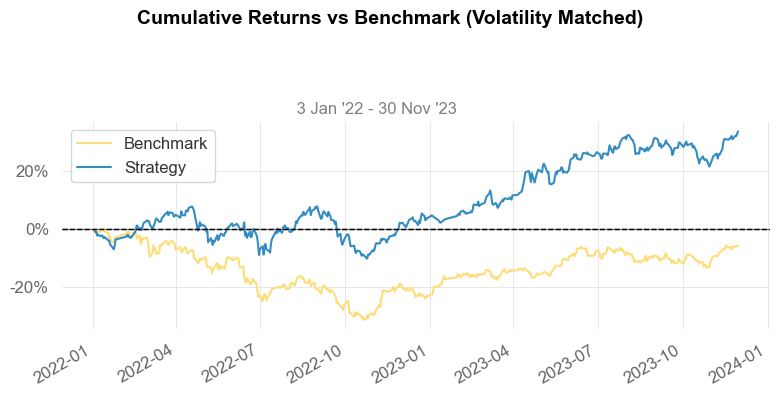

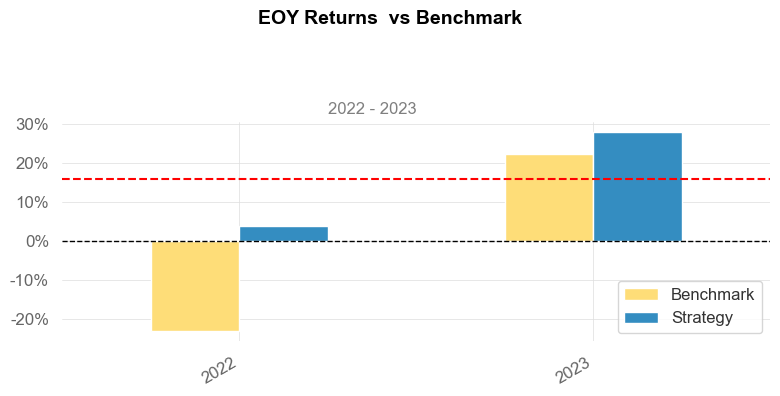

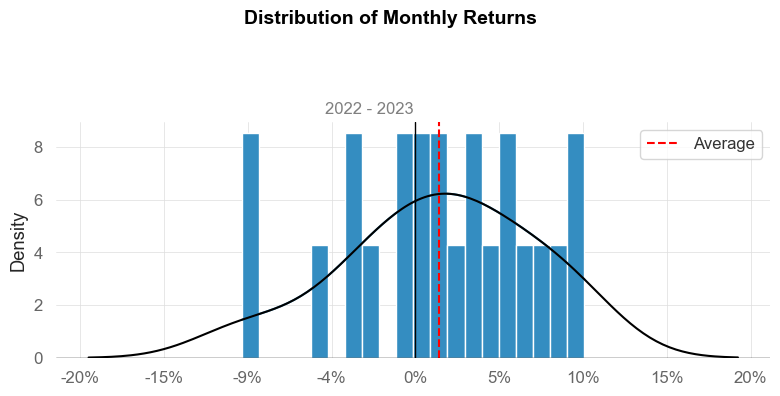

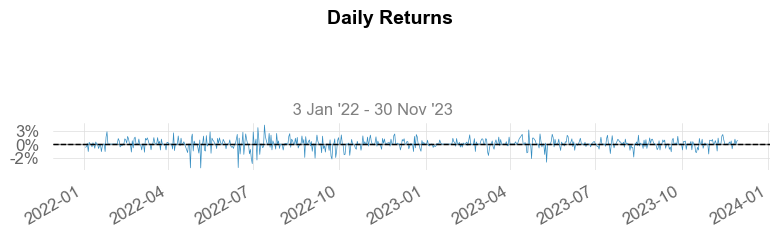

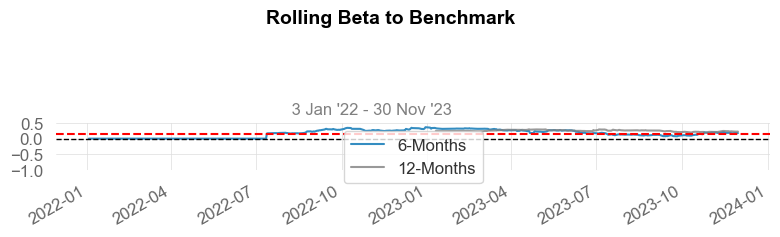

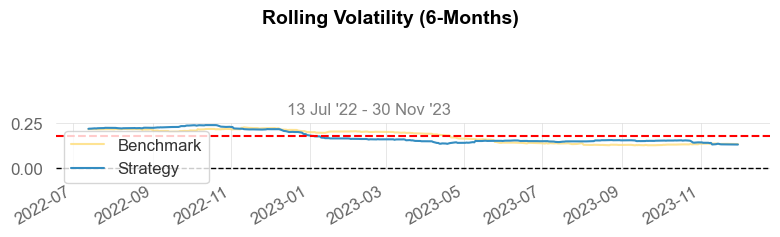

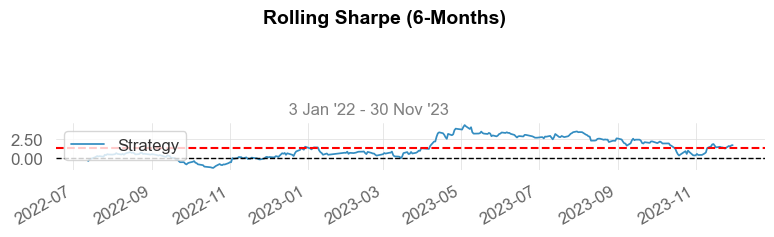

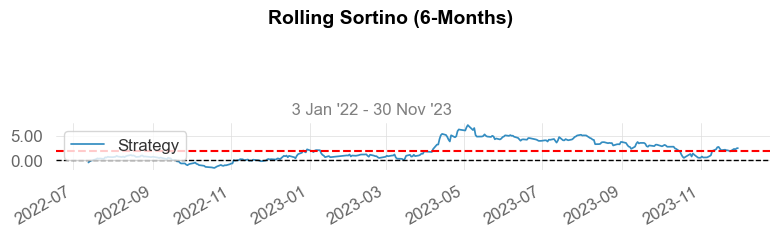

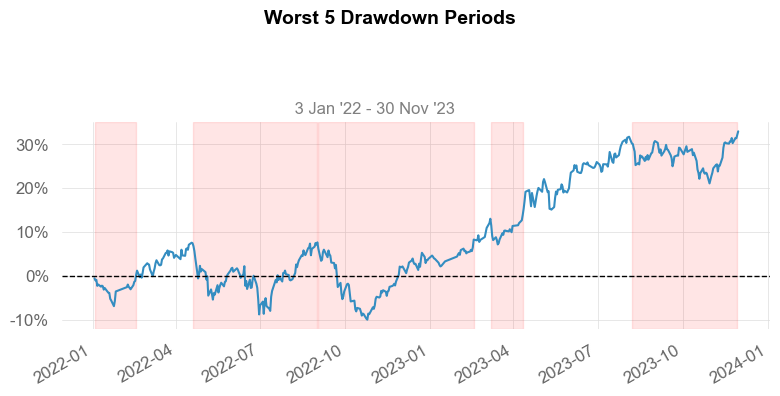

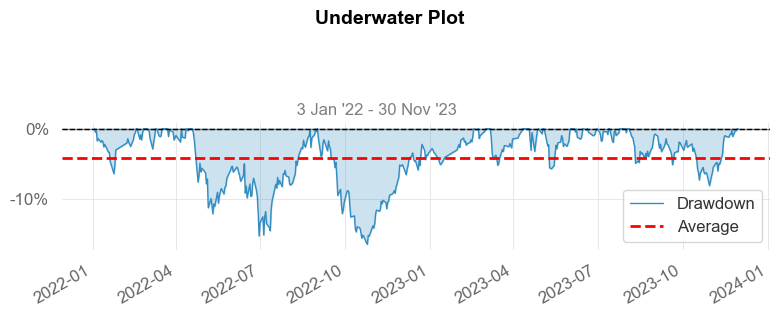

TypeError: pivot() takes 1 positional argument but 4 were given

In [19]:
# unique_list = [
#     'cs_rank(ts_min(TotalSharesHeld,378))',
#     'cs_rank(ts_rank(GrossProfitGrowthRate,252))',
#     'cs_rank(ts_rank(REV_G_m,252))',
#     'cs_rank(ts_min(AboveThousand,252))',
#     'cs_rank(OtherCurrentLiabilities)',
#     'cs_rank(LongTermDebtDueWithinOneYear)',
#     'cs_rank(log(DeferredIncomeTax))',
#     'cs_rank(ts_min(R_F*-1,252))',
#     'cs_rank(FinancialCost)',
#     'cs_rank(NewInvestment/TotalAssets)'
# ]

i = 'cs_rank(ts_rank(GrossProfitGrowthRate,252))'

buy_fee:float=0.001425*0.3
sell_fee:float=0.001425*0.3+0.003
# start_time = '2013-05-15' # 因為 季財報訊號0515才開始有
# end_time = '2021-12-31'
start_time = '2022-01-01'
end_time = '2023-11-30'
stocks = 20
alpha = eval(i)[small_aum_Filter]
top = alpha.apply(lambda row: row.nlargest(stocks), axis=1).fillna(0)
top_equalweight = top.applymap(lambda x: 1/stocks if x != 0 else 0)
# test = top_equalweight.sum(axis =1)
# for index, value in test.items():
#     if 0.001 < value < 0.975:
#         print(f"Error at index {index}: value is {value}")
weight = top_equalweight.loc[start_time:end_time]
expreturn = exp_returns .loc[start_time:end_time]
delta_weight = weight.shift(1) - weight
buy_fees = delta_weight[delta_weight > 0]*(buy_fee)
buy_fees = buy_fees.fillna(0)
sell_fees = delta_weight.abs()[delta_weight < 0]*(sell_fee)
sell_fees = sell_fees.fillna(0)
fee = buy_fees + sell_fees
daily_fee = fee.sum(axis = 1)
daily_profit = (weight * expreturn).sum(axis=1)
daily_returns = daily_profit - daily_fee
summary_df = pd.DataFrame({
'expression':[i],    
'Sharpe Ratio':[sharpe(daily_returns)],
'Annualized Ret': [annual_returns(daily_returns)],
'Max Drawdown':[MDD(daily_returns)],
'Turnover':[turnover(alpha)], 
'Std':[daily_returns.std()],
'IC':[IC(alpha, expreturn, start_time, end_time)],
'IR':[IR(alpha, expreturn, start_time, end_time)]# 這邊的input不同要注意
}, index = ['Performance'])
qs.reports.full(daily_returns,Benchmark)
    

In [15]:
annualized_simple_return = daily_returns.sum() * (252/ len(daily_returns))
annualized_simple_return 

0.06843976307195034

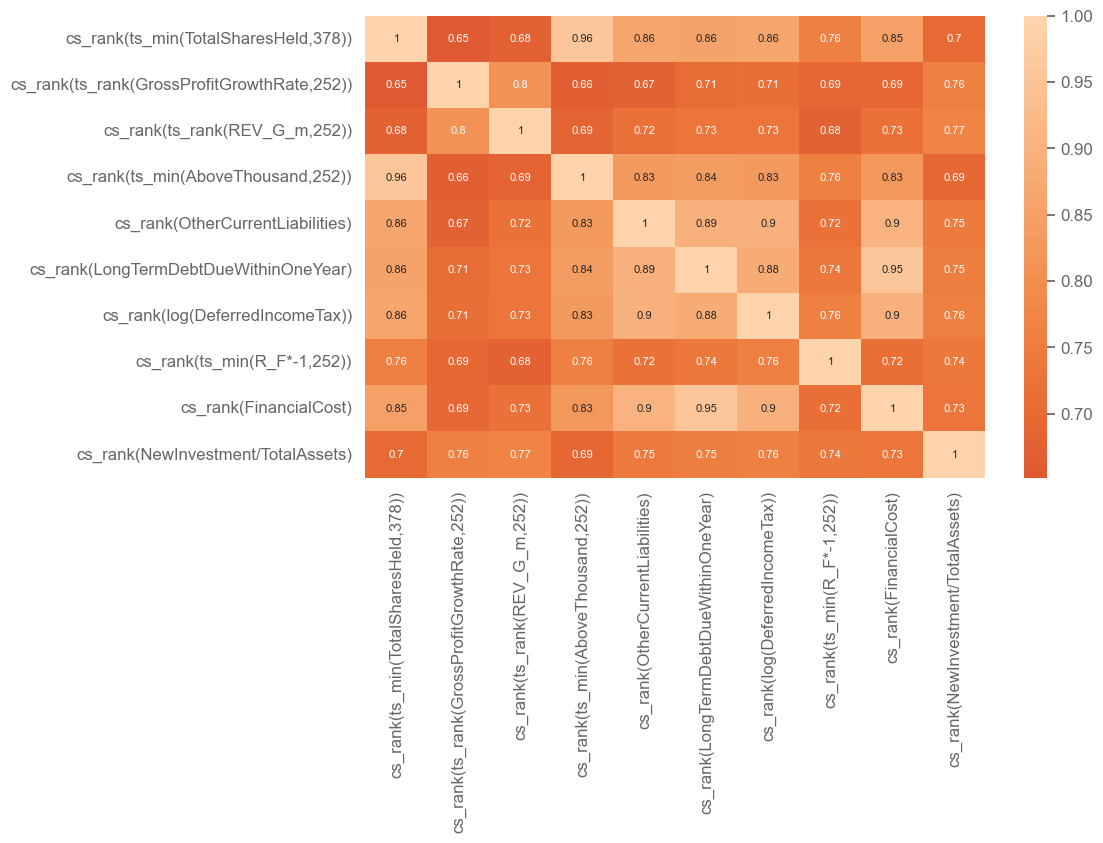

In [10]:
unique_list = [
    'cs_rank(ts_min(TotalSharesHeld,378))',
    'cs_rank(ts_rank(GrossProfitGrowthRate,252))',
    'cs_rank(ts_rank(REV_G_m,252))',
    'cs_rank(ts_min(AboveThousand,252))',
    'cs_rank(OtherCurrentLiabilities)',
    'cs_rank(LongTermDebtDueWithinOneYear)',
    'cs_rank(log(DeferredIncomeTax))',
    'cs_rank(ts_min(R_F*-1,252))',
    'cs_rank(FinancialCost)',
    'cs_rank(NewInvestment/TotalAssets)'
]

AUM = 100000000
buy_fee:float=0.001425*0.3
sell_fee:float=0.001425*0.3+0.003
start_time = '2013-05-15' # 因為 季財報訊號0515才開始有
end_time = '2023-11-30'

correlation_matrix = pd.DataFrame()
# correlation_matrix = pd.concat([correlation_matrix, Benchmark.loc[start_time:end_time]], axis=1, ignore_index = False)

for i in unique_list:
    stocks = 20
    alpha = eval(i)[small_aum_Filter]
    top = alpha.apply(lambda row: row.nlargest(stocks), axis=1) #.fillna(0)
    top = top.applymap(lambda x: not pd.isna(x))
    # top_equalweight = top.applymap(lambda x: 1/stocks if x else 0)
    top_equalweight = ((AUM//stocks) // (Close[top]*1000))*Close[top]*1000 /AUM
    weight = top_equalweight.loc[start_time:end_time]
    expreturn = exp_returns .loc[start_time:end_time]
    delta_weight = weight.shift(1) - weight
    buy_fees = delta_weight[delta_weight > 0]*(buy_fee)
    buy_fees = buy_fees.fillna(0)
    sell_fees = delta_weight.abs()[delta_weight < 0]*(sell_fee)
    sell_fees = sell_fees.fillna(0)
    fee = buy_fees + sell_fees
    daily_fee = fee.sum(axis = 1)
    daily_profit = (weight * expreturn).sum(axis=1)
    daily_returns = daily_profit - daily_fee
    daily_returns = pd.Series(daily_returns, name=i)
    correlation_matrix = pd.concat([correlation_matrix, daily_returns], axis=1, ignore_index = False)
correlation_matrix_P = correlation_matrix.corr()
sns.heatmap(correlation_matrix_P, center=0, annot=True, annot_kws={"size": 8})
plt.show()

### 樣本內回測

In [26]:
multi_alpha = ' cs_rank(ts_min( TotalSharesHeld ,378)) + cs_rank(ts_rank(GrossProfitGrowthRate,252)) + cs_rank(ts_rank(REV_G_m,252)) + cs_rank(ts_min(AboveThousand,252)) + cs_rank(OtherCurrentLiabilities) + cs_rank(LongTermDebtDueWithinOneYear) + cs_rank(log(DeferredIncomeTax)) + cs_rank(ts_min(R_F*-1,252)) + cs_rank(FinancialCost) + cs_rank(NewInvestment/TotalAssets)'

correlation_matrix = pd.DataFrame()
AUM = 100000000
buy_fee:float=0.001425*0.3
sell_fee:float=0.001425*0.3+0.003
start_time = '2013-05-15'
end_time = '2021-12-31'
# start_time = '2022-01-01'
# end_time = '2023-11-30'
stocks = 20
alpha = eval(multi_alpha)[small_aum_Filter]
top = alpha.apply(lambda row: row.nlargest(stocks), axis=1) #.fillna(0)
top = top.applymap(lambda x: not pd.isna(x))
# top_equalweight = top.applymap(lambda x: 1/stocks if x else 0)
top_equalweight = ((AUM//stocks) // (Close[top]*1000))*Close[top]*1000 /AUM
        
weight = top_equalweight.loc[start_time:end_time]
expreturn = exp_returns.loc[start_time:end_time]
delta_weight = weight.shift(1) - weight
buy_fees = delta_weight[delta_weight > 0]*(buy_fee)
buy_fees = buy_fees.fillna(0)
sell_fees = delta_weight.abs()[delta_weight < 0]*(sell_fee)
sell_fees = sell_fees.fillna(0)
fee = buy_fees + sell_fees
daily_fee = fee.sum(axis = 1)
daily_profit = (weight * expreturn).sum(axis=1)
daily_returns = daily_profit - daily_fee
# qs.reports.full(daily_returns,Benchmark)
累積單利報酬 = daily_returns.sum()
累積單利報酬

1.4795353397383462

In [17]:
annualized_simple_return = daily_returns.sum() * (252/ len(daily_returns))
annualized_simple_return 

0.17578637699861538

### 樣本外回測

In [20]:
multi_alpha = ' cs_rank(ts_min( TotalSharesHeld ,378)) + cs_rank(ts_rank(GrossProfitGrowthRate,252)) + cs_rank(ts_rank(REV_G_m,252)) + cs_rank(ts_min(AboveThousand,252)) + cs_rank(OtherCurrentLiabilities) + cs_rank(LongTermDebtDueWithinOneYear) + cs_rank(log(DeferredIncomeTax)) + cs_rank(ts_min(R_F*-1,252)) + cs_rank(FinancialCost) + cs_rank(NewInvestment/TotalAssets)'

correlation_matrix = pd.DataFrame()
AUM = 100000000
buy_fee:float=0.001425*0.3
sell_fee:float=0.001425*0.3+0.003
# start_time = '2013-05-15'
# end_time = '2021-12-31'
start_time = '2022-01-01'
end_time = '2023-11-30'
stocks = 20
alpha = eval(multi_alpha)[small_aum_Filter]
top = alpha.apply(lambda row: row.nlargest(stocks), axis=1) #.fillna(0)
top = top.applymap(lambda x: not pd.isna(x))
# top_equalweight = top.applymap(lambda x: 1/stocks if x else 0)
top_equalweight = ((AUM//stocks) // (Close[top]*1000))*Close[top]*1000 /AUM
        
weight = top_equalweight.loc[start_time:end_time]
expreturn = exp_returns.loc[start_time:end_time]
delta_weight = weight.shift(1) - weight
buy_fees = delta_weight[delta_weight > 0]*(buy_fee)
buy_fees = buy_fees.fillna(0)
sell_fees = delta_weight.abs()[delta_weight < 0]*(sell_fee)
sell_fees = sell_fees.fillna(0)
fee = buy_fees + sell_fees
daily_fee = fee.sum(axis = 1)
daily_profit = (weight * expreturn).sum(axis=1)
daily_returns = daily_profit - daily_fee
# qs.reports.full(daily_returns,Benchmark)
累積單利報酬 = daily_returns.sum()
累積單利報酬

0.3924782281306251

In [33]:
top_equalweight['9941']['2022-01-01':].dropna()#['2022-01-01':'2022-01-31']#.dropna(how ='all',axis = 1)

date
2022-01-03    0.049000
2022-01-04    0.049280
2022-01-05    0.049700
2022-01-06    0.049980
2022-01-07    0.049840
2022-01-10    0.049700
2022-01-11    0.048330
2022-01-12    0.049275
2022-01-13    0.048880
2022-01-14    0.049680
2022-01-17    0.049275
2022-01-18    0.048465
2022-01-19    0.049560
2022-01-20    0.049700
2022-01-21    0.049000
2022-01-24    0.049000
2022-01-25    0.048300
2022-01-26    0.048860
2022-02-07    0.048330
2022-02-08    0.048735
2022-02-09    0.048600
2022-02-10    0.049950
2022-02-11    0.048230
2022-02-14    0.048230
2022-02-15    0.048620
2022-02-16    0.049920
2022-02-17    0.049920
2022-02-18    0.048375
2022-02-21    0.048360
2022-02-22    0.048360
2022-02-23    0.049920
2022-02-24    0.049875
2022-02-25    0.048480
2022-03-01    0.049320
2022-03-02    0.047955
2022-03-03    0.049105
2022-03-04    0.048070
2022-03-07    0.048300
2022-03-08    0.049625
2022-03-09    0.048240
2022-04-19    0.048200
2022-04-20    0.049700
Name: 9941, dtype: float64

In [19]:
annualized_simple_return = daily_returns.sum() * (252/ len(daily_returns))
annualized_simple_return 

0.21315627907094295

### 全樣本回測

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2013-05-15  2013-05-15
End Period                 2023-11-30  2023-11-30
Risk-Free Rate             0.0%        0.0%
Time in Market             91.0%       100.0%

Cumulative Return          478.96%     106.99%
CAGR﹪                     18.11%      7.14%

Sharpe                     1.22        0.52
Prob. Sharpe Ratio         99.99%      94.96%
Smart Sharpe               1.16        0.49
Sortino                    1.65        0.71
Smart Sortino              1.56        0.67
Sortino/√2                 1.17        0.5
Smart Sortino/√2           1.1         0.48
Omega                      1.26        1.26

Max Drawdown               -28.33%     -31.51%
Longest DD Days            441         748
Volatility (ann.)          14.93%      16.24%
R^2                        0.11        0.11
Information Ratio          0.03        0.03
Calmar                     0.64        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-04-30,2015-08-21,2016-07-14,441,-28.333167,-23.433274
2,2020-01-16,2020-03-19,2020-06-30,166,-28.079980,-26.125291
3,2021-04-28,2021-05-13,2021-06-16,49,-17.149857,-15.216436
4,2018-10-01,2018-10-26,2019-09-03,337,-14.057459,-13.103120
5,2021-07-05,2021-10-01,2022-02-17,227,-13.734798,-12.981280


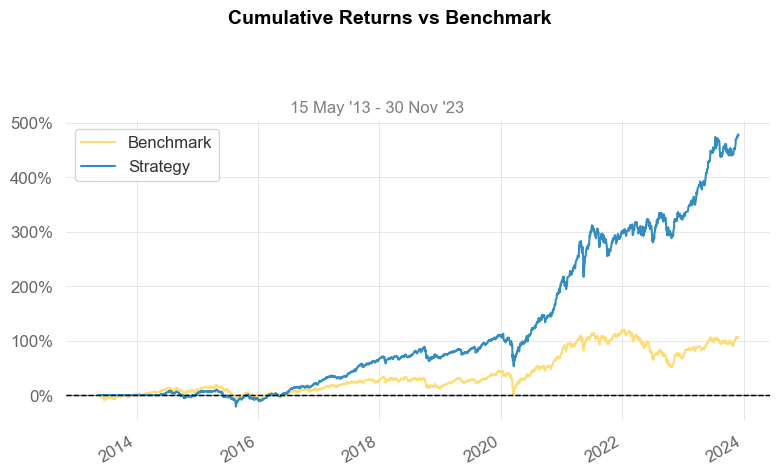

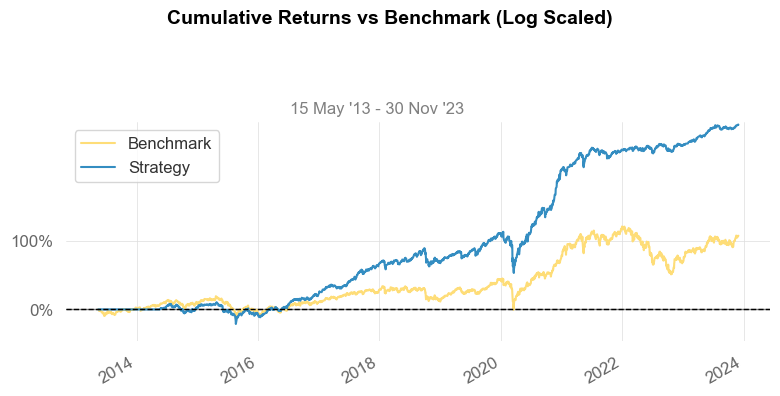

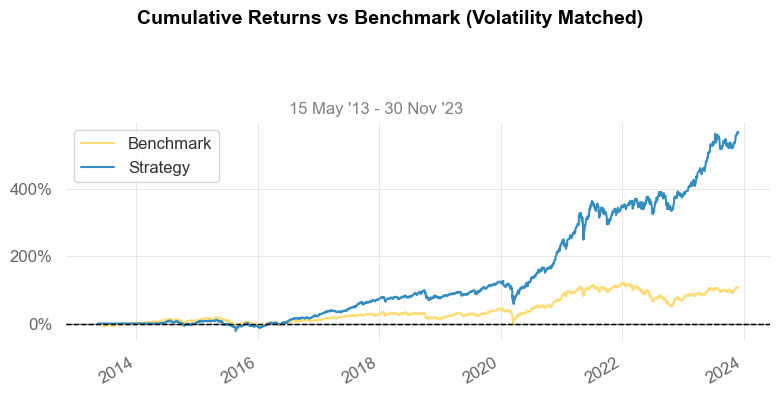

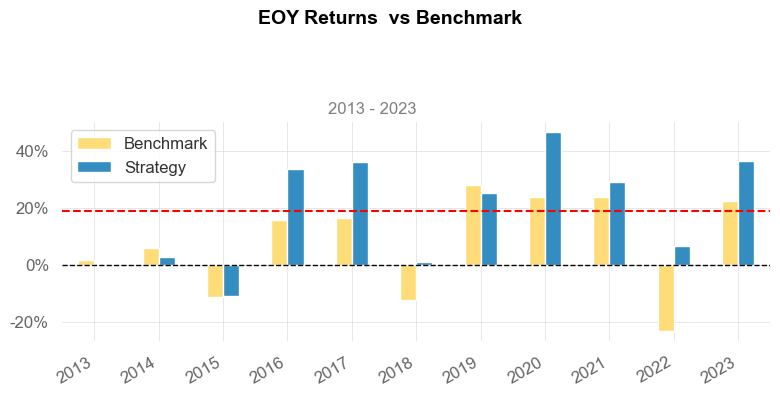

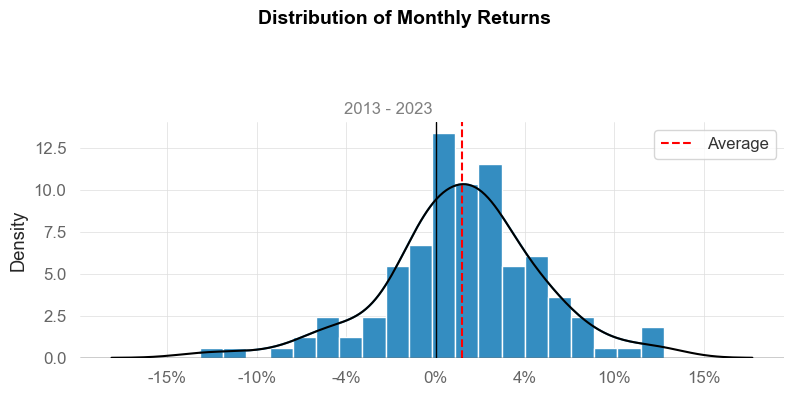

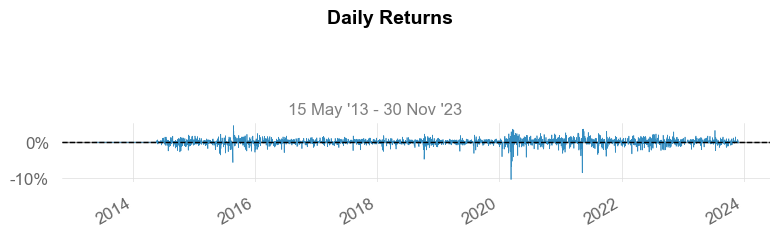

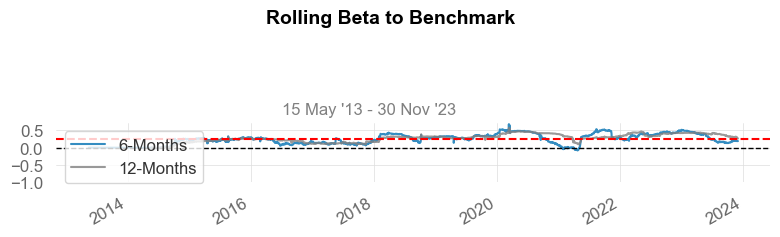

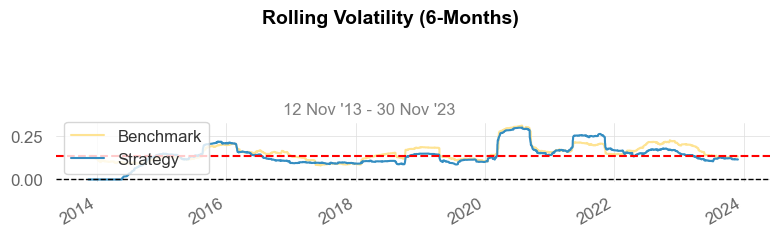

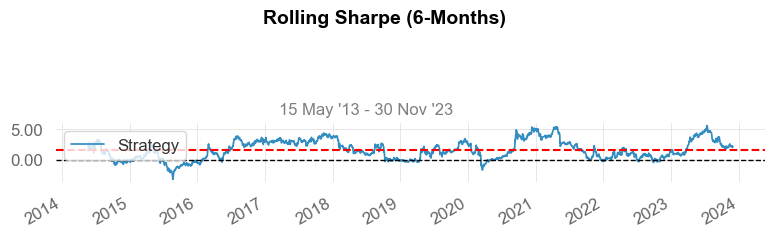

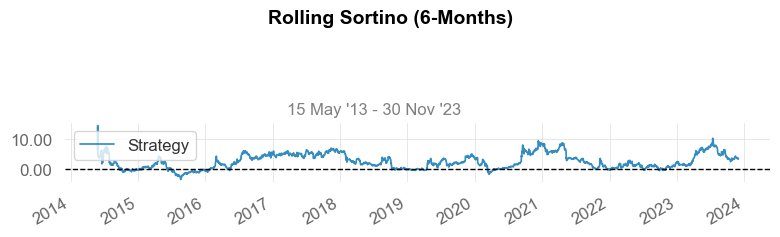

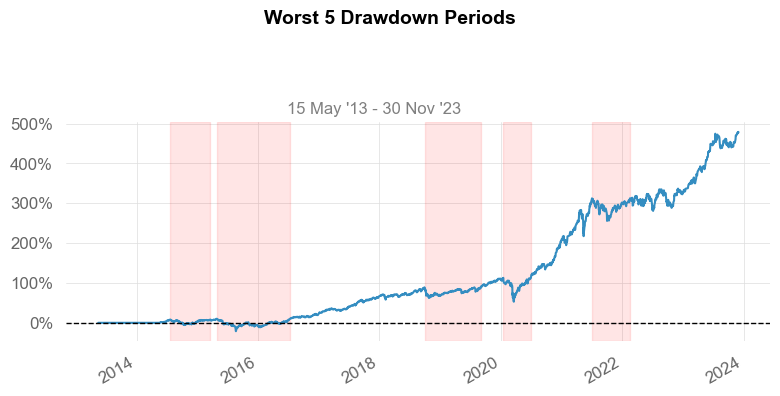

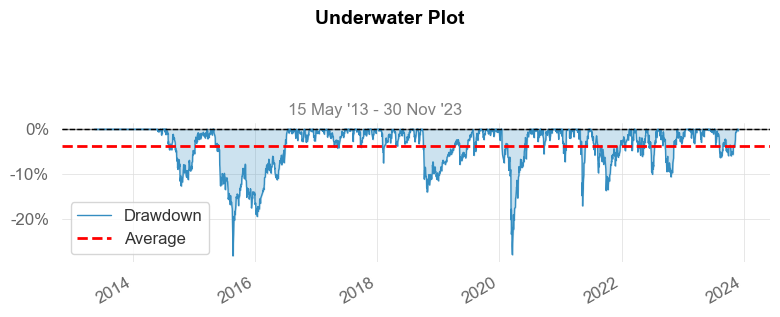

TypeError: pivot() takes 1 positional argument but 4 were given

In [23]:
multi_alpha = ' cs_rank(ts_min( TotalSharesHeld ,378)) + cs_rank(ts_rank(GrossProfitGrowthRate,252)) + cs_rank(ts_rank(REV_G_m,252)) + cs_rank(ts_min(AboveThousand,252)) + cs_rank(OtherCurrentLiabilities) + cs_rank(LongTermDebtDueWithinOneYear) + cs_rank(log(DeferredIncomeTax)) + cs_rank(ts_min(R_F*-1,252)) + cs_rank(FinancialCost) + cs_rank(NewInvestment/TotalAssets)'

correlation_matrix = pd.DataFrame()
AUM = 100000000
buy_fee:float=0.001425*0.3
sell_fee:float=0.001425*0.3+0.003
start_time = '2013-05-15'
end_time = '2023-11-30'
stocks = 20
alpha = eval(multi_alpha)[small_aum_Filter]
top = alpha.apply(lambda row: row.nlargest(stocks), axis=1) #.fillna(0)
top = top.applymap(lambda x: not pd.isna(x))
# top_equalweight = top.applymap(lambda x: 1/stocks if x else 0)
top_equalweight = ((AUM//stocks) // (Close[top]*1000))*Close[top]*1000 /AUM
        
weight = top_equalweight.loc[start_time:end_time]
expreturn = exp_returns.loc[start_time:end_time]
delta_weight = weight.shift(1) - weight
buy_fees = delta_weight[delta_weight > 0]*(buy_fee)
buy_fees = buy_fees.fillna(0)
sell_fees = delta_weight.abs()[delta_weight < 0]*(sell_fee)
sell_fees = sell_fees.fillna(0)
fee = buy_fees + sell_fees
daily_fee = fee.sum(axis = 1)
daily_profit = (weight * expreturn).sum(axis=1)
daily_returns = daily_profit - daily_fee
qs.reports.full(daily_returns,Benchmark)

In [24]:
累積單利報酬 = daily_returns.sum()
累積單利報酬

1.872004874036971

In [22]:
annualized_simple_return# = daily_returns.sum() * (252/ len(daily_returns))
#annualized_simple_return 

0.18249331847478403